# –û—Å–Ω–æ–≤–Ω—ã–µ –≤–∏–¥—ã –Ω–µ–π—Ä–æ—Å–µ—Ç–µ–π (CNN –∏ RNN)

**–†–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫: –ê–ª–µ–∫—Å–µ–π –£–º–Ω–æ–≤**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mryab/dl-hse-ami/blob/master/week03_architectures/homework.ipynb)


–≠—Ç–æ—Ç —Å–µ–º–∏–Ω–∞—Ä –±—É–¥–µ—Ç —Å–æ—Å—Ç–æ—è—Ç—å –∏–∑ –¥–≤—É—Ö —á–∞—Å—Ç–µ–π: —Å–Ω–∞—á–∞–ª–∞ –º—ã –ø–æ–∑–∞–Ω–∏–º–∞–µ–º—Å—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–µ–π —Å–≤–µ—Ä—Ç–æ—á–Ω—ã—Ö –∏ —Ä–µ–∫—É—Ä—Ä–µ–Ω—Ç–Ω—ã—Ö —Å–µ—Ç–µ–π, –∞ –ø–æ—Ç–æ–º –ø–æ–∏—Å—Å–ª–µ–¥—É–µ–º –ø—Ä–æ–±–ª–µ–º—É –∑–∞—Ç—É—Ö–∞—é—â–∏—Ö –∏ –≤–∑—Ä—ã–≤–∞—é—â–∏—Ö—Å—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤.

## –°–≤–µ—Ä—Ç–æ—á–Ω—ã–µ —Å–µ—Ç–∏

–í–µ—Ä–Ω–µ–º—Å—è –≤ –æ—á–µ—Ä–µ–¥–Ω–æ–π —Ä–∞–∑ –∫ –¥–∞—Ç–∞—Å–µ—Ç—É MNIST. –î–ª—è –Ω–∞—á–∞–ª–∞ –∑–∞–≥—Ä—É–∑–∏–º –¥–∞–Ω–Ω—ã–µ –∏ –æ–ø—Ä–µ–¥–µ–ª–∏–º –Ω–µ—Å–∫–æ–ª—å–∫–æ –ø–æ–ª–µ–∑–Ω—ã—Ö —Ñ—É–Ω–∫—Ü–∏–π –∫–∞–∫ –Ω–∞ –ø—Ä–æ—à–ª–æ–º —Å–µ–º–∏–Ω–∞—Ä–µ.

In [1]:
# Load dependencies
!wget --quiet --show-progress "https://raw.githubusercontent.com/mryab/dl-hse-ami/master/week03_architectures/util.py"

util.py             100%[===================>]   3.74K  --.-KB/s    in 0s      


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

In [32]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)    

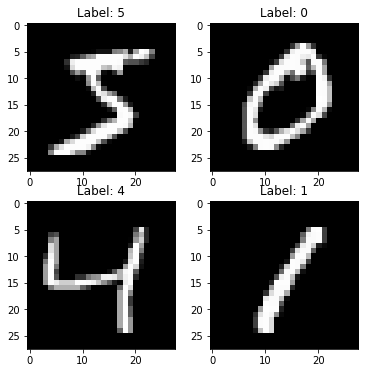

In [27]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [28]:
from util import iterate_minibatches


def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log


def test(model):
    loss_log, acc_log = [], []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
            data = torch.from_numpy(x_batch.astype(np.float32))
            target = torch.from_numpy(y_batch.astype(np.int64))

            output = model(data)
            loss = F.nll_loss(output, target)
            
            pred = torch.max(output, 1)[1].numpy()
            acc = np.mean(pred == y_batch)
            acc_log.append(acc)
            
            loss = loss.item()
            loss_log.append(loss)
    return loss_log, acc_log


def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()


def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

**–ó–∞–¥–∞–Ω–∏–µ 1:** –†–µ–∞–ª–∏–∑—É–π—Ç–µ —Å–≤–µ—Ä—Ç–æ—á–Ω—É—é —Å–µ—Ç—å, –∫–æ—Ç–æ—Ä–∞—è —Å–æ—Å—Ç–æ–∏—Ç –∏–∑ –¥–≤—É—Ö –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω—ã—Ö –ø—Ä–∏–º–µ–Ω–µ–Ω–∏–π —Å–≤–µ—Ä—Ç–∫–∏, relu –∏ max-–ø—É–ª–∏–Ω–≥–∞, –∞ –ø–æ—Ç–æ–º –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω–æ–≥–æ —Å–ª–æ—è. –ü–æ–¥–±–µ—Ä–∏—Ç–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Ç–∞–∫, —á—Ç–æ–±—ã –Ω–∞ –≤—ã—Ö–æ–¥–µ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ —Å–ª–æ—è —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞ –±—ã–ª–∞ 4 x 4 x 16. –í –∫–æ–¥–µ –Ω–∏–∂–µ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –æ–±–µ—Ä—Ç–∫–∞ `nn.Sequential`, –æ–∑–Ω–∞–∫–æ–º—å—Ç–µ—Å—å —Å –µ–µ –∏–Ω—Ç–µ—Ä—Ñ–µ–π—Å–æ–º.

–î–æ–±–µ–π—Ç–µ—Å—å, —á—Ç–æ–±—ã –æ—à–∏–±–∫–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –ø–æ—Å–ª–µ –æ–±—É—á–µ–Ω–∏—è (—Å–º. –Ω–∏–∂–µ) –±—ã–ª–∞ –Ω–µ –≤—ã—à–µ 1.5%.

In [53]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=11, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # self.features = nn.Sequential( # Final error: 2.15%
        #     nn.Conv2d(1, 8, kernel_size=3, padding=2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Conv2d(8, 16, kernel_size=11, padding=2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        # )

        self.classifier = nn.Linear(4 * 4 * 16, 10)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.features(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return F.log_softmax(out, dim=-1)

–ü–æ—Å—á–∏—Ç–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—É—á–∞–µ–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ —Å–µ—Ç–∏ (–ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–µ —Å–µ—Ç–∏ —Å –ø—Ä–æ—à–ª–æ–≥–æ —Å–µ–º–∏–Ω–∞—Ä–∞ –∏–º–µ—é—Ç 30-40 —Ç—ã—Å—è—á –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤).

In [54]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

set_random_seed(42)
model = ConvNet()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 6842


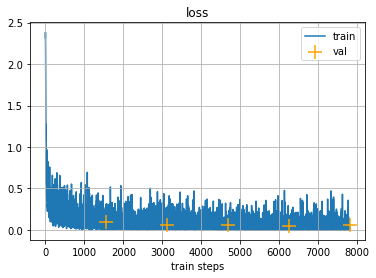

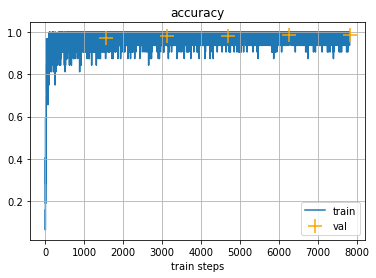

Epoch 4 error = 1.45%
Final error: 1.45%
CPU times: user 2min 25s, sys: 2.95 s, total: 2min 28s
Wall time: 2min 28s


In [55]:
%%time

opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 5)

–ú—ã —Å –ª–µ–≥–∫–æ—Å—Ç—å—é –ø–æ–ª—É—á–∏–ª–∏ –∫–∞—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏ –ª—É—á—à–µ, —á–µ–º –±—ã–ª–æ —Ä–∞–Ω—å—à–µ —Å –ø–æ–º–æ—â—å—é –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã—Ö —Å–µ—Ç–µ–π. –ù–∞ —Å–∞–º–æ–º –¥–µ–ª–µ –¥–ª—è –±–æ–ª–µ–µ —á–µ—Å—Ç–Ω–æ–≥–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—è –Ω—É–∂–Ω–æ –ø–æ–∏—Å—Å–ª–µ–¥–æ–≤–∞—Ç—å –æ–±–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã –∏ –ø–æ–¥–æ–∂–¥–∞—Ç—å –ø–æ–±–æ–ª—å—à–µ –∏—Ç–µ—Ä–∞—Ü–∏–π –¥–æ —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏, –Ω–æ –≤ —Å–∏–ª—É –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω–æ—Å—Ç–∏ –≤—ã—á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã—Ö —Ä–µ—Å—É—Ä—Å–æ–≤ –º—ã —ç—Ç–æ —Å–¥–µ–ª–∞—Ç—å –Ω–µ –º–æ–∂–µ–º. –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∏–∑ –∫–æ—Ç–æ—Ä—ã—Ö "–≤—ã–∂–∞–ª–∏ –º–∞–∫—Å–∏–º—É–º" –º–æ–∂–Ω–æ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –Ω–∞–ø—Ä–∏–º–µ—Ä, –Ω–∞ —ç—Ç–æ–π —Å—Ç—Ä–∞–Ω–∏—Ü–µ: http://yann.lecun.com/exdb/mnist/, –∏ —Ç–∞–º –≤–∏–¥–Ω–æ, —á—Ç–æ –∫–∞—á–µ—Å—Ç–≤–æ —Å–≤–µ—Ä—Ç–æ—á–Ω—ã—Ö —Å–µ—Ç–µ–π –≥–æ—Ä–∞–∑–¥–æ –≤—ã—à–µ. –ê –µ—Å–ª–∏ —Ä–∞–±–æ—Ç–∞—Ç—å —Å –±–æ–ª–µ–µ —Å–ª–æ–∂–Ω—ã–º–∏ –∏–∑–æ—Ä–∞–∂–µ–Ω–∏—è–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Å ImageNet), —Ç–æ —Å–≤–µ—Ä—Ç–æ—á–Ω—ã–µ —Å–µ—Ç–∏ –ø–æ–±–µ–∂–¥–∞—é—Ç —Å –±–æ–ª—å—à–∏–º –æ—Ç—Ä—ã–≤–æ–º.

**–£–ø—Ä–∞–∂–Ω–µ–Ω–∏–µ:** –í—Å–ø–æ–º–Ω–∏—Ç–µ –º–∞—Ç–µ—Ä–∏–∞–ª—ã –ª–µ–∫—Ü–∏–∏ –∏ –æ—Ç–≤–µ—Ç—å—Ç–µ –Ω–∞ –≤–æ–ø—Ä–æ—Å—ã –Ω–∏–∂–µ:
* –ü–æ—á–µ–º—É —Å–≤–µ—Ä—Ç–æ—á–Ω—ã–µ —Å–µ—Ç–∏ –æ–±–ª–∞–¥–∞—é—Ç —Ç–∞–∫–∏–º –ø—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–æ–º –∏–º–µ–Ω–Ω–æ –¥–ª—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π?
* –ü–æ—á–µ–º—É –Ω–µ—Å–º–æ—Ç—Ä—è –Ω–∞ –º–∞–ª–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –æ–±—É—á–µ–Ω–∏–µ —Å–≤–µ—Ä—Ç–æ—á–Ω—ã—Ö —Å–µ—Ç–µ–π –∑–∞–Ω–∏–º–∞–µ—Ç —Ç–∞–∫ –º–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏?

* –ò–∑-–∑–∞ –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ–Ω–Ω–æ–π —Å—Ç—Ä—É–∫—Ç—É—Ä—ã –≤ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è—Ö, –∫–æ—Ç–æ—Ä–æ–π –Ω–µ—Ç –≤ —Ç–∞–±–ª–∏—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –∏ –ø–æ–¥ –∫–æ—Ç–æ—Ä—É—é –∫–∞–∫ —Ä–∞–∑ –∏ –∑–∞—Ç–æ—á–µ–Ω—ã —Å–≤–µ—Ä—Ç–∫–∏ + –∏–∑-–∑–∞ —Å—Ä–∞–≤–Ω–∏—Ç–µ–ª—å–Ω–æ –Ω–µ–±–æ–ª—å—à–æ–≥–æ —á–∏—Å–ª–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤;
* –í–æ–∑–º–æ–∂–Ω–æ, –∏–∑-–∑–∞ —Ç–æ–≥–æ, —á—Ç–æ –æ–ø–µ—Ä–∞—Ü–∏—è —Å–≤–µ—Ä—Ç–∫–∏ –∏ –µ–µ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏—è –º–æ–∂–µ—Ç –±—ã—Ç—å –≤—ã—á–∏—Å–ª–∏—Ç–µ–ª—å–Ω–æ —Ç—Ä—É–¥–æ–µ–º–∫–æ–π.

## –†–µ–∫—É—Ä—Ä–µ–Ω—Ç–Ω—ã–µ —Å–µ—Ç–∏

–î–ª—è —Ä–µ–∫—É—Ä—Ä–µ–Ω—Ç–Ω—ã—Ö —Å–µ—Ç–µ–π –∏—Å–ø–æ–ª—å–∑—É–µ–º –¥–∞—Ç–∞—Å–µ—Ç —Å –∏–º–µ–Ω–∞–º–∏ –∏ –±—É–¥–µ–º –æ–ø—Ä–µ–¥–µ–ª—è—Ç—å –∏–∑ –∫–∞–∫–æ–≥–æ —è–∑—ã–∫–∞ –ø—Ä–æ–∏–∑–æ—à–ª–æ –¥–∞–Ω–Ω–æ–µ –∏–º—è. –î–ª—è —ç—Ç–æ–≥–æ –ø–æ—Å—Ç—Ä–æ–∏–º —Ä–µ–∫—É—Ä—Ä–µ–Ω—Ç–Ω—É—é —Å–µ—Ç—å, –∫–æ—Ç–æ—Ä–∞—è —Å –∏–º–µ–Ω–∞–º–∏ –Ω–∞ —É—Ä–æ–≤–Ω–µ —Å–∏–º–≤–æ–ª–æ–≤. –î–ª—è –Ω–∞—á–∞–ª–∞ —Å–∫–∞—á–∞–µ–º —Ñ–∞–π–ª—ã –∏ –∫–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º –∏—Ö –∫ —É–¥–æ–±–Ω–æ–º—É —Ñ–æ—Ä–º–∞—Ç—É (–º–æ–∂–Ω–æ –Ω–µ –æ—Å–æ–±–æ –≤–Ω–∏–∫–∞—Ç—å –≤ —ç—Ç–æ—Ç –∫–æ–¥).

In [87]:
# –ù–∞ Windows –ø—Ä–∏–¥–µ—Ç—Å—è —Å–∫–∞—á–∞—Ç—å –∞—Ä—Ö–∏–≤ –ø–æ —Å—Å—ã–ª–∫–µ (~3Mb) –∏ —Ä–∞—Å–ø–∞–∫–æ–≤–∞—Ç—å —Å–∞–º–æ—Å—Ç–æ—è—Ç–µ–ª—å–Ω–æ
!wget --quiet --show-progress https://download.pytorch.org/tutorial/data.zip
!unzip -q ./data.zip # -f  >:(

data.zip            100%[===================>]   2.75M  16.9MB/s    in 0.2s    


In [88]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('≈ölus√†rski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

['data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/German.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Portuguese.txt', 'data/names/French.txt']
Slusarski


–û–ø—Ä–µ–¥–µ–ª–∏–º –Ω–µ—Å–∫–æ–ª—å–∫–æ —É–¥–æ–±–Ω—ã—Ö —Ñ—É–Ω–∫—Ü–∏–π –¥–ª—è –∫–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏–∏ –±—É–∫–≤ –∏ —Å–ª–æ–≤ –≤ —Ç–µ–Ω–∑–æ—Ä—ã.

**–ó–∞–¥–∞–Ω–∏–µ 2**: –Ω–∞–ø–∏—à–∏—Ç–µ –ø–æ—Å–ª–µ–¥–Ω—é—é —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –∫–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏–∏ —Å–ª–æ–≤–∞ –≤ —Ç–µ–Ω–∑–æ—Ä.

In [89]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    return torch.stack([letterToTensor(letter) for letter in line])

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**–ó–∞–¥–∞–Ω–∏–µ 3:** –†–µ–∞–ª–∏–∑—É–π—Ç–µ –æ–¥–Ω–æ—Å–ª–æ–π–Ω—É—é —Ä–µ–∫—É—Ä—Ä–µ–Ω—Ç–Ω—É—é —Å–µ—Ç—å.

In [114]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)

    def forward(self, input, hidden):
        _, hidden = self.rnn(input, hidden)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnncell = RNNCell(n_letters, n_hidden)

–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –±—É–¥–µ–º –æ—Å—É—â–µ—Å—Ç–≤–ª—è—Ç—å –ø—Ä–∏ –ø–æ–º–æ—â–∏ –ª–∏–Ω–µ–π–Ω–æ–≥–æ –∫–ª–∞—Å—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ –ø–æ–≤–µ—Ä—Ö —Å–∫—Ä—ã—Ç—ã—Ö —Å–æ—Å—Ç–æ—è–Ω–∏–π —Å–µ—Ç–∏.

In [115]:
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))

–ü—Ä–æ–≤–µ—Ä–∏–º, —á—Ç–æ –≤—Å–µ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ —Ä–∞–±–æ—Ç–∞–µ—Ç: –≤—ã—Ö–æ–¥—ã –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ –¥–æ–ª–∂–Ω—ã –±—ã—Ç—å –ª–æ–≥-–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—è–º–∏.

In [116]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input, hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.8856, -2.7774, -2.9473, -2.8007, -2.8858, -2.8843, -3.0462, -2.9454,
         -3.0379, -2.8284, -2.8939, -2.8672, -2.8894, -2.8896, -2.9442, -2.7983,
         -2.8185, -2.9341]], grad_fn=<LogSoftmaxBackward0>)
tensor(1., grad_fn=<SumBackward0>)


In [120]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input[0], hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.8856, -2.7774, -2.9473, -2.8007, -2.8858, -2.8843, -3.0462, -2.9454,
         -3.0379, -2.8284, -2.8939, -2.8672, -2.8894, -2.8896, -2.9442, -2.7983,
         -2.8185, -2.9341]], grad_fn=<LogSoftmaxBackward0>)
tensor(1., grad_fn=<SumBackward0>)


–î–ª—è –ø—Ä–æ—Å—Ç–æ—Ç—ã –≤ —ç—Ç–æ—Ç —Ä–∞–∑ –±—É–¥–µ–º –æ–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞—Ç—å –Ω–µ –ø–æ –º–∏–Ω–∏-–±–∞—Ç—á–∞–º, –∞ –ø–æ –æ—Ç–¥–µ–ª—å–Ω—ã–º –ø—Ä–∏–º–µ—Ä–∞–º. –ù–∏–∂–µ –Ω–µ—Å–∫–æ–ª—å–∫–æ –ø–æ–ª–µ–∑–Ω—ã—Ö —Ñ—É–Ω–∫—Ü–∏–π –¥–ª—è —ç—Ç–æ–≥–æ.

In [121]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Stolarz
category = Greek / line = Haritopoulos
category = Russian / line = Gagarin
category = Greek / line = Close
category = German / line = Hutmacher
category = English / line = Power
category = Portuguese / line = Barros
category = Russian / line = Hantimerov
category = Czech / line = Bruckner
category = Vietnamese / line = Kieu


**–ó–∞–¥–∞–Ω–∏–µ 4:** –†–µ–∞–ª–∏–∑—É–π—Ç–µ –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –æ—Ç–≤–µ—Ç–∞ –≤ —Ñ—É–Ω–∫—Ü–∏–∏ `train`. –ï—Å–ª–∏ –≤—Å–µ —Å–¥–µ–ª–∞–Ω–æ –ø—Ä–∞–≤–∏–ª—å–Ω–æ, —Ç–æ —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–µ –¥–æ–ª–∂–Ω–∞ –±—ã—Ç—å –Ω–µ –º–µ–Ω–µ–µ 70%.

  0%|          | 0/50000 [00:00<?, ?it/s]

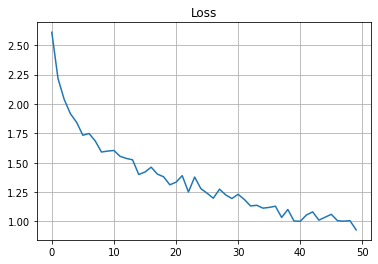

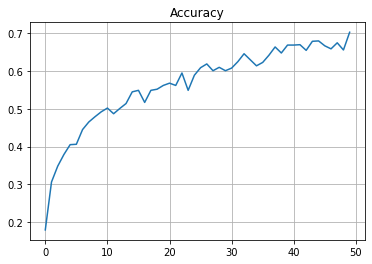

In [122]:
from tqdm.auto import tqdm

def train(category, category_tensor, line_tensor, optimizer):
    hidden = rnncell.initHidden()

    rnncell.zero_grad()
    classifier.zero_grad()

    output = classifier(rnncell(line_tensor.squeeze(), hidden))

    loss = F.nll_loss(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    acc = (categoryFromOutput(output)[0] == category)

    return loss.item(), acc

n_iters = 50000
plot_every = 1000

current_loss = 0
all_losses = []
current_acc = 0
all_accs = []

n_hidden = 128

rnncell = RNNCell(n_letters, n_hidden)
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))
params = list(rnncell.parameters()) + list(classifier.parameters())
opt = torch.optim.RMSprop(params, lr=0.001)
for iter in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    loss, acc = train(category, category_tensor, line_tensor, opt)
    current_loss += loss
    current_acc += acc

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accs.append(current_acc / plot_every)
        current_acc = 0
        
plt.figure()
plt.title("Loss")
plt.plot(all_losses)
plt.grid()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(all_accs)
plt.grid()
plt.show()

In [123]:
all_accs[-1]

0.703

## –ó–∞—Ç—É—Ö–∞—é—â–∏–µ –∏ –≤–∑—Ä—ã–≤–∞—é—â–∏–µ—Å—è –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã

–≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã –±—É–¥–µ–º –ø—Ä–æ–≤–æ–¥–∏—Ç—å –æ–ø—è—Ç—å –Ω–∞ –¥–∞—Ç–∞—Å–µ—Ç–µ MNIST, –Ω–æ –±—É–¥–µ–º —Ä–∞–±–æ—Ç–∞—Ç—å —Å –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–º–∏ —Å–µ—Ç—è–º–∏. –í —ç—Ç–æ–º —Ä–∞–∑–¥–µ–ª–µ –º—ã –Ω–µ –±—É–¥–µ–º –ø—ã—Ç–∞—Ç—å—Å—è –ø–æ–¥–æ–±—Ä–∞—Ç—å –±–æ–ª–µ–µ —É–¥–∞—á–Ω—É—é –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É, –Ω–∞–º –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ —Ç–æ–ª—å–∫–æ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –Ω–∞ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è –≥–ª—É–±–æ–∫–∏—Ö —Å–µ—Ç–µ–π.

In [128]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

–î–ª—è —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–æ–≤ –Ω–∞–º –ø–æ–Ω–∞–¥–æ–±–∏—Ç—Å—è —Ä–µ–∞–ª–∏–∑–æ–≤–∞—Ç—å —Å–µ—Ç—å, –≤ –∫–æ—Ç–æ—Ä–æ–π –º–æ–∂–Ω–æ –ª–µ–≥–∫–æ –º–µ–Ω—è—Ç—å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–µ–≤. –¢–∞–∫–∂–µ —ç—Ç–∞ —Å–µ—Ç—å –¥–æ–ª–∂–Ω–∞ —Å–æ—Ö—Ä–∞–Ω—è—Ç—å –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã –Ω–∞ –≤—Å–µ—Ö —Å–ª–æ—è—Ö, —á—Ç–æ–±—ã –ø–æ—Ç–æ–º –º—ã –º–æ–≥–ª–∏ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –Ω–∞ –∏—Ö –≤–µ–ª–∏—á–∏–Ω—ã.

**–ó–∞–¥–∞–Ω–∏–µ 5:** –¥–æ–ø–∏—à–∏—Ç–µ –Ω–µ–¥–æ—Å—Ç–∞—é—â—É—é —á–∞—Å—Ç—å –∫–æ–¥–∞ –Ω–∏–∂–µ.

In [146]:
class DeepDenseNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0, self.activation]
        
        for i in range(1, n_layers - 1):
            l = nn.Linear(hidden_size, hidden_size)
            self.layers.extend([l, self.activation])
            self.weights.append(l.weight)
            
        l = nn.Linear(hidden_size, 10)
        self.layers.append(l)
        self.weights.append(l.weight)
        
        self.seq = nn.Sequential(*self.layers)
        
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        out = self.seq(x)
        return F.log_softmax(out, dim=-1)

–ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä—É–µ–º –Ω–∞—à–∏ —Ñ—É–Ω–∫—Ü–∏–∏ –æ–±—É—á–µ–Ω–∏—è, —á—Ç–æ–±—ã –æ–Ω–∏ —Ç–∞–∫–∂–µ —Ä–∏—Å–æ–≤–∞–ª–∏ –≥—Ä–∞—Ñ–∏–∫–∏ –∏–∑–º–µ–Ω–µ–Ω–∏—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤.

In [147]:
import scipy.sparse.linalg

def train_epoch_grad(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    grads = [[] for l in model.weights]
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        
        for g, l in zip(grads, model.weights):
            g.append(np.linalg.norm(l.grad.numpy()))
    return loss_log, acc_log, grads


def train_grad(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    grads_log = None

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc, grads = train_epoch_grad(model, opt, batchsize=batchsize)
        if grads_log is None:
            grads_log = grads
        else:
            for a, b in zip(grads_log, grads):
                a.extend(b)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        # display all metrics
        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')    

        plt.figure()
        all_vals = []
        for i, g in enumerate(grads_log):
            w = np.ones(100)
            w /= w.sum()
            vals = np.convolve(w, g, mode='valid')
            plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log))))
            all_vals.extend(vals)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

**–ó–∞–¥–∞–Ω–∏–µ 6:**
* –û–±—É—á–∏—Ç–µ —Å–µ—Ç–∏ –≥–ª—É–±–∏–Ω—ã 10 –∏ –±–æ–ª—å—à–µ —Å —Å–∏–≥–º–æ–∏–¥–æ–π –≤ –∫–∞—á–µ—Å—Ç–≤–µ –∞–∫—Ç–∏–≤–∞—Ü–∏–∏. –ò—Å—Å–ª–µ–¥—É–π—Ç–µ, –∫–∞–∫ –≥–ª—É–±–∏–Ω–∞ –≤–ª–∏—è–µ—Ç –Ω–∞ –∫–∞—á–µ—Å—Ç–≤–æ –æ–±—É—á–µ–Ω–∏—è –∏ –ø–æ–≤–µ–¥–µ–Ω–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤ –Ω–∞ –¥–∞–ª–µ–∫–∏—Ö –æ—Ç –≤—ã—Ö–æ–¥–∞ —Å–ª–æ—è—Ö.
* –¢–µ–ø–µ—Ä—å –∑–∞–º–µ–Ω–∏—Ç–µ –∞–∫—Ç–∏–≤–∞—Ü–∏—é –Ω–∞ ReLU –∏ –ø–æ—Å–º–æ—Ç—Ä–∏—Ç–µ, —á—Ç–æ –ø–æ–ª—É—á–∏—Ç—Å—è.

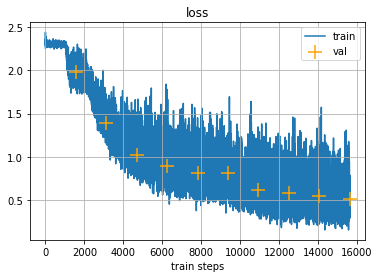

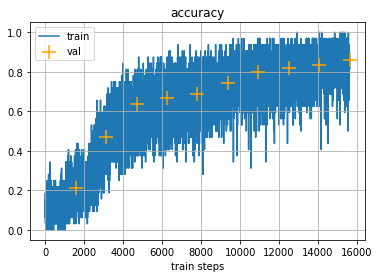

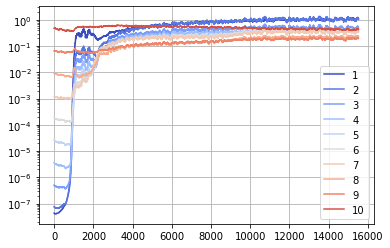

In [148]:
model = DeepDenseNet(10, 40, nn.Sigmoid())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_grad(model, opt, 10)

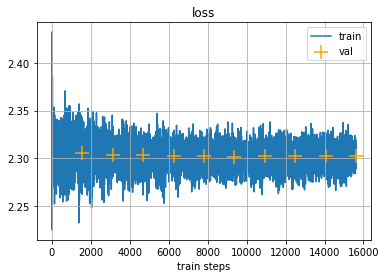

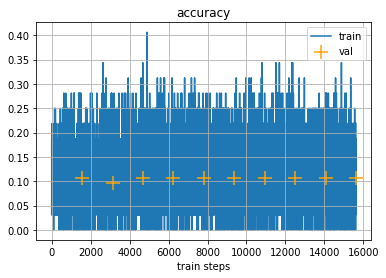

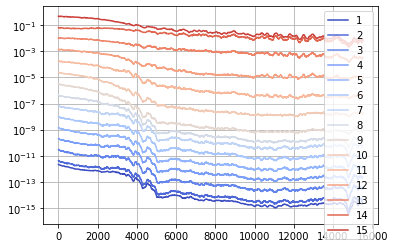

In [149]:
model = DeepDenseNet(15, 40, nn.Sigmoid())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_grad(model, opt, 10)

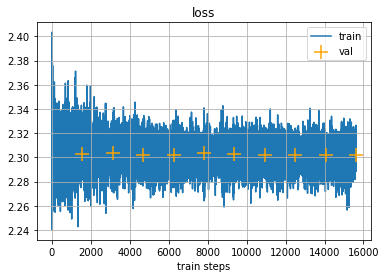

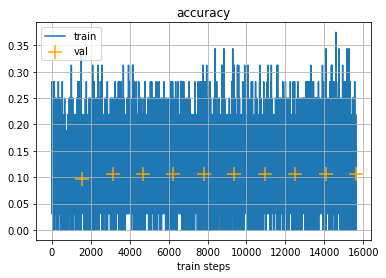

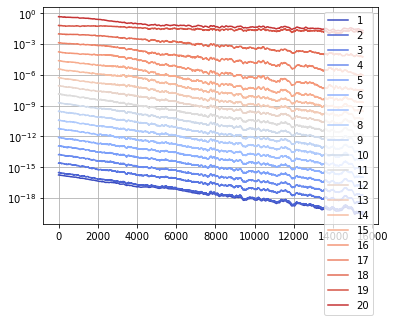

In [150]:
model = DeepDenseNet(20, 40, nn.Sigmoid())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_grad(model, opt, 10)

–í–∏–¥–Ω–æ, —á—Ç–æ —á–µ–º –±–æ–ª—å—à–µ —Å–ª–æ–µ–≤, —Ç–µ–º —Ö—É–∂–µ –∏–¥–µ—Ç –æ–±—É—á–µ–Ω–∏–µ –∏ —Ç–µ–º –º–µ–Ω—å—à–µ –Ω–æ—Ä–º—ã –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤ –Ω–∞ —Ä–∞–Ω–Ω–∏—Ö —Å–ª–æ—è—Ö (–¥–ª—è –≥–ª—É–±–∏–Ω—ã 15, 20 –æ–Ω–∏ –¥–∞–∂–µ –Ω–µ –æ–±—É—á–∞—é—Ç—Å—è –∏–∑-–∑–∞ –∑–∞—Ç—É—Ö–∞–Ω–∏—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞).

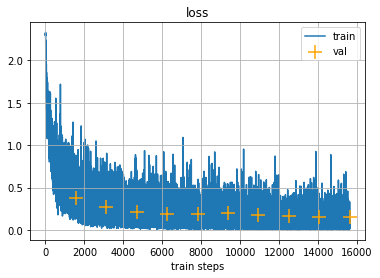

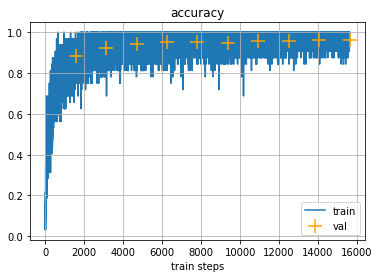

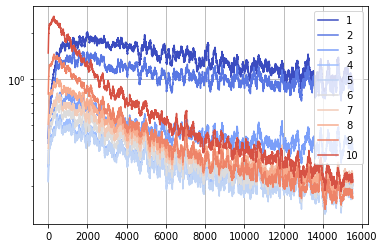

In [151]:
model = DeepDenseNet(10, 40, nn.ReLU())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_grad(model, opt, 10)

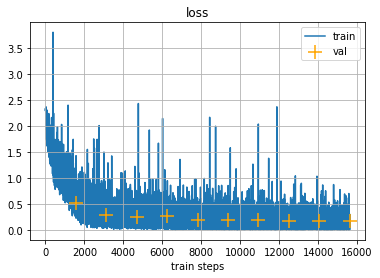

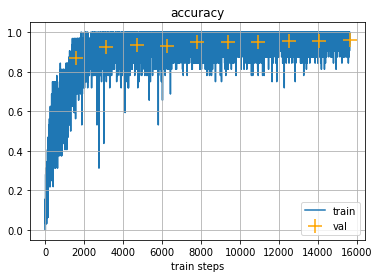

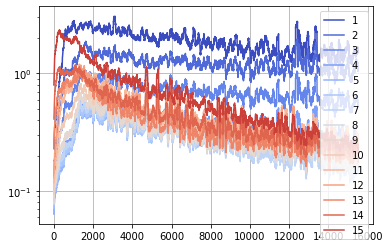

In [152]:
model = DeepDenseNet(15, 40, nn.ReLU())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_grad(model, opt, 10)

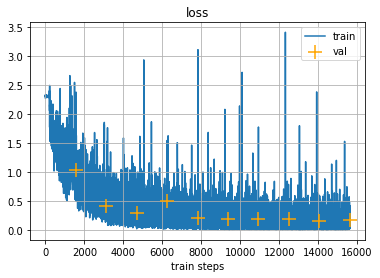

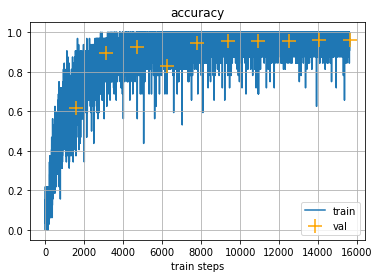

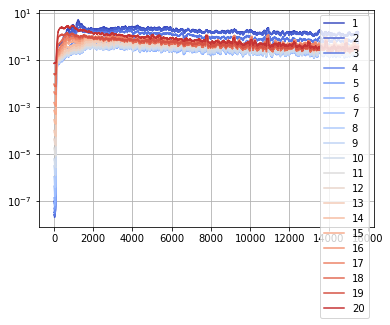

In [153]:
model = DeepDenseNet(20, 40, nn.ReLU())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_grad(model, opt, 10)

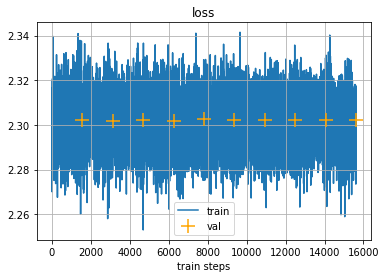

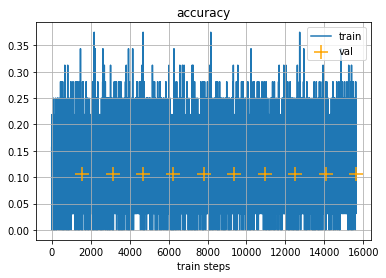

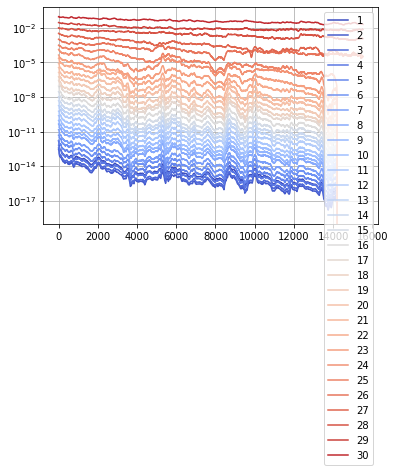

In [154]:
model = DeepDenseNet(30, 40, nn.ReLU())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_grad(model, opt, 10)

–ï—Å–ª–∏ –∑–∞–º–µ–Ω–∏—Ç—å —Å–∏–≥–º–æ–∏–¥—É –Ω–∞ relu –≤ —Å–µ—Ç–∏ c 10-20 —Å–ª–æ—è–º–∏, —Ç–æ –ø—Ä–æ–±–ª–µ–º—ã —Å –æ–±—É—á–µ–Ω–∏–µ–º –∏ –∑–∞—Ç—É—Ö–∞–Ω–∏–µ–º –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤ –ø—Ä–æ–ø–∞–¥–∞—é—Ç. –û–¥–Ω–∞–∫–æ, —Å –±–æ–ª—å—à–µ–π –≥–ª—É–±–∏–Ω–æ–π –æ–Ω–∏ –≤–æ–∑–≤—Ä–∞—â–∞—é—Ç—Å—è.

–¢–µ–ø–µ—Ä—å –ø–æ–ø—Ä–æ–±—É–µ–º –¥–æ–±–∞–≤–∏—Ç—å –≤ —Å–µ—Ç—å skip-connections (–ø–æ –ø—Ä–∏–º–µ—Ä—É ResNet) –≤–º–µ—Å—Ç–æ –∑–∞–º–µ–Ω—ã —Å–∏–≥–º–æ–∏–¥—ã –Ω–∞ relu –∏ –ø–æ—Å–º–æ—Ç—Ä–∏–º, —á—Ç–æ –ø–æ–ª—É—á–∏—Ç—Å—è. –ó–∞–ø–∏—Ö–Ω—É—Ç—å –≤—Å–µ —Å–ª–æ–∏ –≤ `nn.Sequential` –∏ –ø—Ä–æ—Å—Ç–æ –∏—Ö –ø—Ä–∏–º–µ–Ω–∏—Ç—å —Ç–µ–ø–µ—Ä—å –Ω–µ –ø–æ–ª—É—á–∏—Ç—Å—è &mdash; –≤–º–µ—Å—Ç–æ —ç—Ç–æ–≥–æ –º—ã –∏—Ö –ø—Ä–∏–º–µ–Ω–∏–º –≤—Ä—É—á–Ω—É—é. –ù–æ –ø–æ–ª–æ–∂–∏—Ç—å –∏—Ö –≤ –æ—Ç–¥–µ–ª—å–Ω—ã–π –º–æ–¥—É–ª—å `nn.ModuleList` –≤—Å–µ —Ä–∞–≤–Ω–æ –Ω—É–∂–Ω–æ, –∏–Ω–∞—á–µ torch –Ω–µ —Å–º–æ–∂–µ—Ç –∏—Ö –Ω–∞–π—Ç–∏ –∏ –æ–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞—Ç—å.

**–ó–∞–¥–∞–Ω–∏–µ 7:** –¥–æ–ø–∏—à–∏—Ç–µ –Ω–µ–¥–æ—Å—Ç–∞—é—â—É—é —á–∞—Å—Ç—å –∫–æ–¥–∞ –Ω–∏–∂–µ.

In [162]:
class DeepDenseResNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]
        
        for i in range(1, n_layers - 1):
            l = nn.Linear(hidden_size, hidden_size)
            self.layers.append(l)
            self.weights.append(l.weight)
            
        l = nn.Linear(hidden_size, 10)
        self.layers.append(l)
        self.weights.append(l.weight)
        
        self.linear_layers = nn.ModuleList(self.layers)
        
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        x = self.activation()(self.linear_layers[0](x))
        for layer in self.linear_layers[1:-1]:
            x = self.activation()(layer(x)) + x
        x = self.linear_layers[-1](x)
        return F.log_softmax(x, dim=-1)

–£–±–µ–¥–∏–º—Å—è, —á—Ç–æ —Ç–∞–∫–∞—è —Å–µ—Ç—å –æ—Ç–ª–∏—á–Ω–æ —É—á–∏—Ç—Å—è –¥–∞–∂–µ –Ω–∞ –±–æ–ª—å—à–æ–º —á–∏—Å–ª–µ —Å–ª–æ–µ–≤.

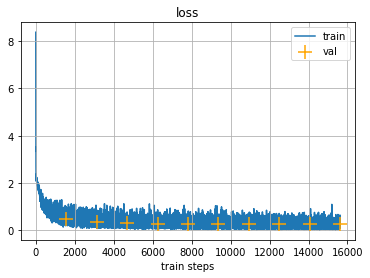

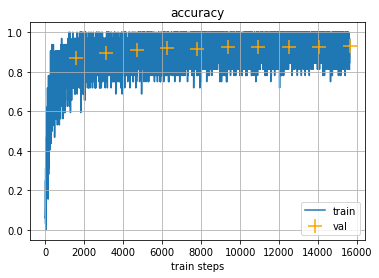

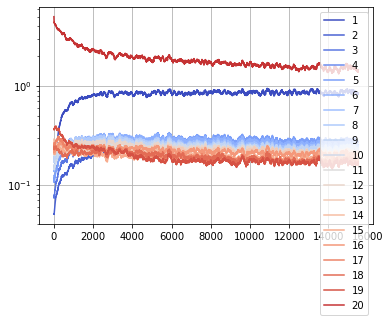

In [163]:
model = DeepDenseResNet(n_layers=20, hidden_size=10, activation=nn.Sigmoid)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 10)

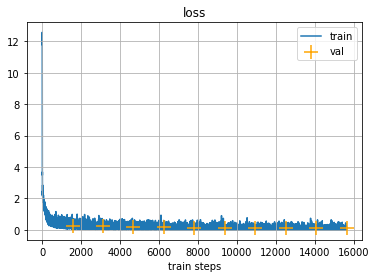

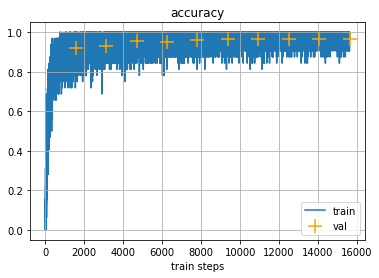

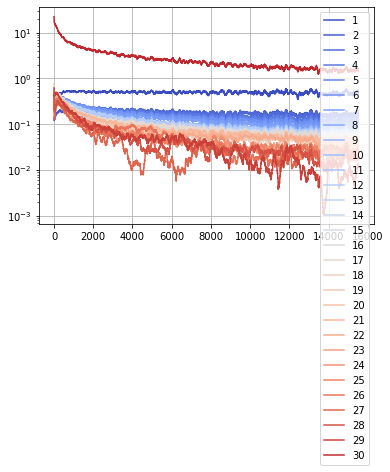

In [164]:
model = DeepDenseResNet(n_layers=30, hidden_size=40, activation=nn.Sigmoid)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 10)

–†–∞–Ω–µ–µ –ø—Ä–∏ —Ç–∞–∫–æ–π –∂–µ –≥–ª—É–±–∏–Ω–µ –∏ —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏ —Å–∫—Ä—ã—Ç–æ–≥–æ —Å–ª–æ—è –º—ã –Ω–µ —Å–º–æ–≥–ª–∏ –æ–±—É—á–∏—Ç—å —Å–µ—Ç—å —Å –∞–∫—Ç–∏–≤–∞—Ü–∏–µ–π relu, –∞ —Å–µ–π—á–∞—Å –≤—Å—ë –ø–æ–ª—É—á–∏–ª–æ—Å—å! ü•≥